In [ ]:
from copy import copy
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
N = 30
q = 1
T = 5000
np.random.seed(0)
alphas = [80/np.sqrt(np.sum([((4*np.pi**2)**k)*((j/2)**(2*k)) for k in range(3)])) for j in range(2*N + 1)]
D_2m = np.sum(4*alphas)

In [ ]:
def join_arrs(a0, arr1, arr2):
    new_arr = np.zeros(len(arr1) + len(arr2))
    new_arr[::2] = arr1
    new_arr[1::2] = arr2
    new_arr = np.concatenate(([a0], new_arr))
    return new_arr

def solve_euler(h, q):
    t = symbols('t')
    x = Function('x')
    C1 = symbols('C1')
    C2 = symbols('C2')
    x = dsolve(- diff(x(t), t, t) + q**2*x(t) - h , x(t)).rhs
    cond1 = x.subs(t, 0) - x.subs(t, 1)
    cond2 = diff(x, t).subs(t, 0) - diff(x, t).subs(t, 1)
    solution = solve([cond1, cond2], [C1, C2])
    x = x.subs(C1, solution[C1]).subs(C2, solution[C2])
    return x

def pop_fourier_coefs(func):
    a0 =  np.trapezoid(func(np.linspace(0, 1, 100)), np.linspace(0, 1, 100))
    an = np.zeros(N)
    bn = np.zeros(N)

    for n in range(1, N+1):
        an[n-1] =  np.trapezoid(func(np.linspace(0, 1, 100)) * np.sqrt(2)*np.cos(n * 2*np.pi * np.linspace(0, 1, 100)), np.linspace(0, 1, 100))
        bn[n-1] =  np.trapezoid(func(np.linspace(0, 1, 100)) * np.sqrt(2)*np.sin(n * 2*np.pi * np.linspace(0, 1, 100)), np.linspace(0, 1, 100))

    return a0, an, bn

def fourier_series(t, a0, an, bn, N):
    return a0 + np.sum([an[n] * np.sqrt(2)*np.cos((n+1) * 2*np.pi * t) + bn[n] * np.sqrt(2)*np.sin((n+1) * 2*np.pi * t) for n in range(N)])


## $\psi$ = 1.5

In [ ]:
# Symbolic function setup
x_func = Function('x')
t = symbols('t')
psi = 1.5  # Frequency parameter

# Define forcing function and solution
h_sp = 10 * pi**2 * cos(2 * psi * pi * t)
h = lambdify(t, h_sp, 'numpy')  # Convert to numeric function
x_sp = solve_euler(h_sp, q)  # Solve ODE
x = lambdify(t, x_sp, 'numpy')  # Convert solution to numeric

# Compute Fourier coefficients
a0, an, bn = pop_fourier_coefs(x)
h_a0, h_an, h_bn = pop_fourier_coefs(h)
x_hat = join_arrs(a0, an, bn)  # Combined solution coefficients
h_hat = join_arrs(h_a0, h_an, h_bn)  # Combined forcing coefficients

# Gradient and objective functions
def grad_J(w, j):
    """Compute gradient component j"""
    freq_term = q**2 + (2*np.pi)**2 * np.ceil(j/2)**2
    return alphas[j] * freq_term * w[j] - np.sqrt(alphas[j]) * h_hat[j]

def J_n(w):
    """Compute objective value"""
    freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
    return 0.5*np.sum(alphas * freq_terms * w**2) - np.sum(np.sqrt(alphas) * h_hat * w)

# Initialize variables
w_iter = np.zeros((T, 2*N + 1))  # Weight history
Regret_J_n, Regret_J_n_sqrt = [], []  # Regret metrics
Dif_J_n = []  # Objective differences
grads = []  # Gradient norms
x_hat_normalized = x_hat / np.sqrt(alphas)  # Normalized target

# Main optimization loop
for i in range(T-1):
    # Compute gradient and its norm
    vec = np.array([grad_J(w_iter[i], k) for k in range(2*N+1)])
    norm_sq = np.dot(vec, vec)
    grads.append(norm_sq)

    # Adaptive learning rate
    eta = np.sqrt(2)/2 * (D_2m / np.sqrt(np.sum(grads)))

    # Update weights
    for j in range(2*N + 1):
        w_iter[i+1, j] = w_iter[i, j] - eta * grad_J(w_iter[i], j)

    # Track performance
    current_diff = J_n(w_iter[i+1]) - J_n(x_hat_normalized)
    Dif_J_n.append(current_diff)
    Regret_J_n.append(np.mean(Dif_J_n))

In [ ]:
np.abs(J_n(w_iter[i+1]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(7.578343544523136e-05)

In [ ]:
Regret_J_n[-1]

np.float64(1399.8070562098633)

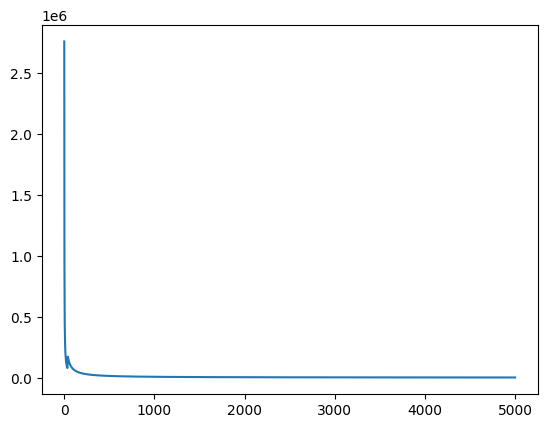

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = N(0, 0.03)

In [ ]:
# Symbolic setup and initialization
x_func = Function('x')  # Symbolic function
t = symbols('t')        # Symbolic time variable
q = 1                   # System parameter
w_iter = np.zeros((T, 2*N + 1))  # Weight matrix
psi = np.random.normal(0, 0.03, T)  # psi values for each timestamp

# Tracking variables
Regret_J_n, Regret_J_n_sqrt = [], []  # Regret metrics
Dif_J_n = []  # Objective differences
grads = []    # Gradient norms

# Precompute frequency terms
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
sqrt_alphas = np.sqrt(alphas)
alpha_freq = alphas * freq_terms  # Combined coefficients

for i in range(T-1):
    # System dynamics for current psi
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp, 'numpy')
    x_sp = solve_euler(h_sp, q)
    x_func = lambdify(t, x_sp, 'numpy')

    # Fourier analysis
    a0, an, bn = pop_fourier_coefs(x_func)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)  # Solution coefficients
    h_hat = join_arrs(h_a0, h_an, h_bn)  # Forcing coefficients

    # Gradient and objective computations
    grad_J_vec = alpha_freq * w_iter[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w_iter[i]**2) - np.sum(sqrt_alphas * h_hat * w_iter[i])

    # Adaptive learning rate
    norm_sq = np.dot(grad_J_vec, grad_J_vec)
    grads.append(norm_sq)
    eta = np.sqrt(2)/2 * (D_2m/np.sqrt(np.sum(grads)))

    # Weight update
    w_iter[i+1] = w_iter[i] - eta * grad_J_vec

    # Regret computation
    x_opt = x_hat/sqrt_alphas
    J_n_opt = 0.5*np.sum(alpha_freq * x_opt**2) - np.sum(sqrt_alphas * h_hat * x_opt)
    current_diff = J_n_current - J_n_opt
    Dif_J_n.append(current_diff)

    # Update regret metrics
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w_iter[i+1]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(0.01053021366806206)

In [ ]:
Regret_J_n[-1]

np.float64(1383.4316537693105)

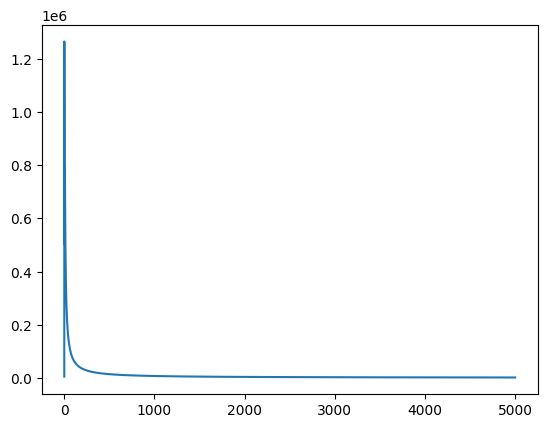

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T)

In [ ]:
# Symbolic setup and initialization
x_func = Function('x')  # Symbolic function
t = symbols('t')        # Symbolic time variable
q = 1                   # System parameter
w_iter = np.zeros((T, 2*N + 1))  # Weight matrix
psi = np.linspace(2, 3, T)  # psi values for each timestep

# Tracking variables
Regret_J_n, Regret_J_n_sqrt = [], []  # Regret metrics
Dif_J_n = []  # Objective differences
grads = []    # Gradient norms

# Precompute frequency terms
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
sqrt_alphas = np.sqrt(alphas)
alpha_freq = alphas * freq_terms  # Combined coefficients

for i in range(T-1):
    # System dynamics for current psi
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp, 'numpy')
    x_sp = solve_euler(h_sp, q)
    x_func = lambdify(t, x_sp, 'numpy')

    # Fourier analysis
    a0, an, bn = pop_fourier_coefs(x_func)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)  # Solution coefficients
    h_hat = join_arrs(h_a0, h_an, h_bn)  # Forcing coefficients

    # Gradient and objective computations
    grad_J_vec = alpha_freq * w_iter[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w_iter[i]**2) - np.sum(sqrt_alphas * h_hat * w_iter[i])

    # Adaptive learning rate
    norm_sq = np.dot(grad_J_vec, grad_J_vec)
    grads.append(norm_sq)
    eta = np.sqrt(2)/2 * (D_2m/np.sqrt(np.sum(grads)))

    # Weight update
    w_iter[i+1] = w_iter[i] - eta * grad_J_vec

    # Regret computation
    x_opt = x_hat/sqrt_alphas
    J_n_opt = 0.5*np.sum(alpha_freq * x_opt**2) - np.sum(sqrt_alphas * h_hat * x_opt)
    current_diff = J_n_current - J_n_opt
    Dif_J_n.append(current_diff)

    # Update regret metrics
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w_iter[i+1]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(2.9943107326957374e-05)

In [ ]:
Regret_J_n[-1]

np.float64(1156.9147540217061)

## $\psi$ = [0.5]*int(T/2) + [1.5]*int(T/2)

In [ ]:
# Symbolic setup and initialization
x_func = Function('x')  # Symbolic function
t = symbols('t')        # Symbolic time variable
q = 1                   # System parameter
w_iter = np.zeros((T, 2*N + 1))  # Weight matrix
psi = [0.5]*int(T/2) + [1.5]*int(T/2)  # psi values for each timestep

# Tracking variables
Regret_J_n, Regret_J_n_sqrt = [], []  # Regret metrics
Dif_J_n = []  # Objective differences
grads = []    # Gradient norms

# Precompute frequency terms
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
sqrt_alphas = np.sqrt(alphas)
alpha_freq = alphas * freq_terms  # Combined coefficients

for i in range(T-1):
    # System dynamics for current psi
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp, 'numpy')
    x_sp = solve_euler(h_sp, q)
    x_func = lambdify(t, x_sp, 'numpy')

    # Fourier analysis
    a0, an, bn = pop_fourier_coefs(x_func)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)  # Solution coefficients
    h_hat = join_arrs(h_a0, h_an, h_bn)  # Forcing coefficients

    # Gradient and objective computations
    grad_J_vec = alpha_freq * w_iter[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w_iter[i]**2) - np.sum(sqrt_alphas * h_hat * w_iter[i])

    # Adaptive learning rate
    norm_sq = np.dot(grad_J_vec, grad_J_vec)
    grads.append(norm_sq)
    eta = np.sqrt(2)/2 * (D_2m/np.sqrt(np.sum(grads)))

    # Weight update
    w_iter[i+1] = w_iter[i] - eta * grad_J_vec

    # Regret computation
    x_opt = x_hat/sqrt_alphas
    J_n_opt = 0.5*np.sum(alpha_freq * x_opt**2) - np.sum(sqrt_alphas * h_hat * x_opt)
    current_diff = J_n_current - J_n_opt
    Dif_J_n.append(current_diff)

    # Update regret metrics
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w_iter[i+1]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(7.578343545233679e-05)

In [ ]:
Regret_J_n[-1]

np.float64(1397.096398552298)

## $\psi$ = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)

In [ ]:
# Symbolic setup and initialization
x_func = Function('x')  # Symbolic function
t = symbols('t')        # Symbolic time variable
q = 1                   # System parameter
w_iter = np.zeros((T, 2*N + 1))  # Weight matrix
psi = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)  # psi values for each timestep

# Tracking variables
Regret_J_n, Regret_J_n_sqrt = [], []  # Regret metrics
Dif_J_n = []  # Objective differences
grads = []    # Gradient norms

# Precompute frequency terms
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
sqrt_alphas = np.sqrt(alphas)
alpha_freq = alphas * freq_terms  # Combined coefficients

for i in range(T-1):
    # System dynamics for current psi
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp, 'numpy')
    x_sp = solve_euler(h_sp, q)
    x_func = lambdify(t, x_sp, 'numpy')

    # Fourier analysis
    a0, an, bn = pop_fourier_coefs(x_func)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)  # Solution coefficients
    h_hat = join_arrs(h_a0, h_an, h_bn)  # Forcing coefficients

    # Gradient and objective computations
    grad_J_vec = alpha_freq * w_iter[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w_iter[i]**2) - np.sum(sqrt_alphas * h_hat * w_iter[i])

    # Adaptive learning rate
    norm_sq = np.dot(grad_J_vec, grad_J_vec)
    grads.append(norm_sq)
    eta = np.sqrt(2)/2 * (D_2m/np.sqrt(np.sum(grads)))

    # Weight update
    w_iter[i+1] = w_iter[i] - eta * grad_J_vec

    # Regret computation
    x_opt = x_hat/sqrt_alphas
    J_n_opt = 0.5*np.sum(alpha_freq * x_opt**2) - np.sum(sqrt_alphas * h_hat * x_opt)
    current_diff = J_n_current - J_n_opt
    Dif_J_n.append(current_diff)

    # Update regret metrics
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w_iter[i+1]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(0.6934939072345028)

In [ ]:
Regret_J_n[-1]

np.float64(1166.1088259448431)

## Strong convexity (take another $\eta$)

## $\psi$ = 1.5

In [ ]:
# Symbolic math setup
x_func = Function('x')  # Define symbolic function
t = symbols('t')        # Symbolic time variable
psi = 1.5               # Frequency parameter

# Define forcing function and convert to numeric
h_sp = 10 * pi**2 * cos(2 * psi * pi * t)
h = lambdify(t, h_sp, 'numpy')

# Solve system and get numeric solution
x_sp = solve_euler(h_sp, q)
x = lambdify(t, x_sp, 'numpy')

# Compute Fourier coefficients
a0, an, bn = pop_fourier_coefs(x)       # For solution
h_a0, h_an, h_bn = pop_fourier_coefs(h) # For forcing function
x_hat = join_arrs(a0, an, bn)           # Combined solution coeffs
h_hat = join_arrs(h_a0, h_an, h_bn)     # Combined forcing coeffs

# Gradient and objective functions
def grad_J(w, j):
    """Compute gradient for j-th component"""
    freq = q**2 + (2*np.pi)**2 * (j//2 + 1)**2  # Precompute frequency term
    return alphas[j] * freq * w[j] - np.sqrt(alphas[j]) * h_hat[j]

def J_n(w):
    """Compute objective function value"""
    freqs = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
    return 0.5*np.sum(alphas * freqs * w**2) - np.sum(np.sqrt(alphas) * h_hat * w)

# Initialize variables
w_iter = np.zeros((T, 2*N + 1))        # Weight matrix
x_hat_normalized = x_hat/np.sqrt(alphas)  # Normalized target
Regret_J_n = []                         # Average regret
Dif_J_n = []                            # Objective differences
grads = []                              # Gradient norms

# Main optimization loop
for i in range(T-1):
    # Compute gradient and its norm
    grad = np.array([grad_J(w_iter[i], j) for j in range(2*N+1)])
    grads.append(np.dot(grad, grad))

    # Update learning rate (decaying)
    eta = 1/(10*(i+1))

    # Update weights
    for j in range(2*N + 1):
        w_iter[i+1,j] = w_iter[i,j] - eta * grad_J(w_iter[i], j)

    # Track performance
    current_diff = J_n(w_iter[i+1]) - J_n(x_hat_normalized)
    Dif_J_n.append(current_diff)
    Regret_J_n.append(np.mean(Dif_J_n))

In [ ]:
np.abs(J_n(w_iter[i+1]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(7.578343544878408e-05)

In [ ]:
Regret_J_n[-1]

np.float64(18.485781013330378)

## $\psi$ = N(0, 0.03)

In [ ]:
# Symbolic setup
x_func = Function('x')  # Solution function
t = symbols('t')        # Time variable
q = 1                   # System parameter

# Initialize arrays
w_iter = np.zeros((T, 2*N + 1))  # Weight matrix
psi = np.random.normal(0, 0.03, T)  # psi values for every timestamp

# Tracking variables
Regret_J_n = []         # Average regret
Regret_J_n_sqrt = []    # Scaled regret
Dif_J_n = []            # Objective differences

# Precompute frequency terms
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
sqrt_alphas = np.sqrt(alphas)
alpha_freq = alphas * freq_terms  # Combined coefficients

for i in range(T-1):
    # Current system dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)  # Forcing function
    h = lambdify(t, h_sp, 'numpy')       # Numeric function
    x_sp = solve_euler(h_sp, q)          # Solve ODE
    x_func = lambdify(t, x_sp, 'numpy')  # Numeric solution

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x_func)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)        # Solution coeffs
    h_hat = join_arrs(h_a0, h_an, h_bn)  # Forcing coeffs

    # Gradient and objective
    grad_J_vec = alpha_freq * w_iter[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w_iter[i]**2) - np.sum(sqrt_alphas * h_hat * w_iter[i])

    # Update weights with decaying learning rate
    eta = 1/(10*(i+1))
    w_iter[i+1] = w_iter[i] - eta * grad_J_vec

    # Compute optimal solution difference
    x_opt = x_hat/sqrt_alphas
    J_n_opt = 0.5*np.sum(alpha_freq * x_opt**2) - np.sum(sqrt_alphas * h_hat * x_opt)
    current_diff = J_n_current - J_n_opt

    # Update regret metrics
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w_iter[i+1]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(0.0005278338949210593)

In [ ]:
Regret_J_n[-1]

np.float64(47842025.86198178)

## $\psi$ = np.linspace(2, 3, T)

In [ ]:
# Symbolic setup
x_func = Function('x')  # Solution function
t = symbols('t')        # Time variable
q = 1                   # System parameter

# Initialize arrays
w_iter = np.zeros((T, 2*N + 1))  # Weight matrix
psi = np.linspace(2, 3, T)  # psi values for every timestamp

# Tracking variables
Regret_J_n = []         # Average regret
Regret_J_n_sqrt = []    # Scaled regret
Dif_J_n = []            # Objective differences

# Precompute frequency terms
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
sqrt_alphas = np.sqrt(alphas)
alpha_freq = alphas * freq_terms  # Combined coefficients

for i in range(T-1):
    # Current system dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)  # Forcing function
    h = lambdify(t, h_sp, 'numpy')       # Numeric function
    x_sp = solve_euler(h_sp, q)          # Solve ODE
    x_func = lambdify(t, x_sp, 'numpy')  # Numeric solution

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x_func)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)        # Solution coeffs
    h_hat = join_arrs(h_a0, h_an, h_bn)  # Forcing coeffs

    # Gradient and objective
    grad_J_vec = alpha_freq * w_iter[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w_iter[i]**2) - np.sum(sqrt_alphas * h_hat * w_iter[i])

    # Update weights with decaying learning rate
    eta = 1/(10*(i+1))
    w_iter[i+1] = w_iter[i] - eta * grad_J_vec

    # Compute optimal solution difference
    x_opt = x_hat/sqrt_alphas
    J_n_opt = 0.5*np.sum(alpha_freq * x_opt**2) - np.sum(sqrt_alphas * h_hat * x_opt)
    current_diff = J_n_current - J_n_opt

    # Update regret metrics
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w_iter[i+1]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(4.689713266998736)

In [ ]:
Regret_J_n[-1]

np.float64(159002.68583505286)

## $\psi$ = [0.5]*(T/2) + [1.5]*(T/2) (switch)

In [ ]:
# Symbolic setup
x_func = Function('x')  # Solution function
t = symbols('t')        # Time variable
q = 1                   # System parameter

# Initialize arrays
w_iter = np.zeros((T, 2*N + 1))  # Weight matrix
psi = [0.5]*int(T/2) + [1.5]*int(T/2)  # psi values for every timestamp

# Tracking variables
Regret_J_n = []         # Average regret
Regret_J_n_sqrt = []    # Scaled regret
Dif_J_n = []            # Objective differences

# Precompute frequency terms
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
sqrt_alphas = np.sqrt(alphas)
alpha_freq = alphas * freq_terms  # Combined coefficients

for i in range(T-1):
    # Current system dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)  # Forcing function
    h = lambdify(t, h_sp, 'numpy')       # Numeric function
    x_sp = solve_euler(h_sp, q)          # Solve ODE
    x_func = lambdify(t, x_sp, 'numpy')  # Numeric solution

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x_func)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)        # Solution coeffs
    h_hat = join_arrs(h_a0, h_an, h_bn)  # Forcing coeffs

    # Gradient and objective
    grad_J_vec = alpha_freq * w_iter[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w_iter[i]**2) - np.sum(sqrt_alphas * h_hat * w_iter[i])

    # Update weights with decaying learning rate
    eta = 1/(10*(i+1))
    w_iter[i+1] = w_iter[i] - eta * grad_J_vec

    # Compute optimal solution difference
    x_opt = x_hat/sqrt_alphas
    J_n_opt = 0.5*np.sum(alpha_freq * x_opt**2) - np.sum(sqrt_alphas * h_hat * x_opt)
    current_diff = J_n_current - J_n_opt

    # Update regret metrics
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w_iter[i+1]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(0.0014240471545043931)

In [ ]:
Regret_J_n[-1]

np.float64(39.19185318279258)

## $\psi$ = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)

In [ ]:
# Symbolic setup
x_func = Function('x')  # Solution function
t = symbols('t')        # Time variable
q = 1                   # System parameter

# Initialize arrays
w_iter = np.zeros((T, 2*N + 1))  # Weight matrix
psi = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)  # psi values for every timestamp

# Tracking variables
Regret_J_n = []         # Average regret
Regret_J_n_sqrt = []    # Scaled regret
Dif_J_n = []            # Objective differences

# Precompute frequency terms
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
sqrt_alphas = np.sqrt(alphas)
alpha_freq = alphas * freq_terms  # Combined coefficients

for i in range(T-1):
    # Current system dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)  # Forcing function
    h = lambdify(t, h_sp, 'numpy')       # Numeric function
    x_sp = solve_euler(h_sp, q)          # Solve ODE
    x_func = lambdify(t, x_sp, 'numpy')  # Numeric solution

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x_func)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)        # Solution coeffs
    h_hat = join_arrs(h_a0, h_an, h_bn)  # Forcing coeffs

    # Gradient and objective
    grad_J_vec = alpha_freq * w_iter[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w_iter[i]**2) - np.sum(sqrt_alphas * h_hat * w_iter[i])

    # Update weights with decaying learning rate
    eta = 1/(10*(i+1))
    w_iter[i+1] = w_iter[i] - eta * grad_J_vec

    # Compute optimal solution difference
    x_opt = x_hat/sqrt_alphas
    J_n_opt = 0.5*np.sum(alpha_freq * x_opt**2) - np.sum(sqrt_alphas * h_hat * x_opt)
    current_diff = J_n_current - J_n_opt

    # Update regret metrics
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w_iter[i+1]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(4.98832552721097)

In [ ]:
Regret_J_n[-1]

np.float64(366858763115.36444)